In [ ]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4625b06f88e3b580d4c355165ec9b9179f748fd9cb0502f63733536e2b1434da
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# import libraries
import numpy as np
import pandas as 1381591r
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql.types import IntegerType
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time

In [ ]:
spark = SparkSession \
        .builder \
        .appName("Sparkify-Small") \
        .getOrCreate()

In [ ]:
df = spark.read.json('mini_sparkify_event_data (1).json')

In [ ]:
# number of records
df.count()

280616

In [ ]:
df = df[df.userId != ""]
df.count()

272400

In [ ]:
# drop null values
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df.count()

272400

In [ ]:
# define churn when a user cancels
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [ ]:
df = df.withColumn("churn", churn("page"))

In [ ]:
window_churn = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_churn = df.withColumn('churn',max('churn').over(window_churn))

In [ ]:
df_churn.show(5)

+---------------+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|_corrupt_record|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+---------------+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|           null|         Evanescence|Logged In|    Colin|     M|            0|  Larson|237.11302| paid|Dallas-Fort Worth...|   PUT|   NextSong|1537982255000|      256|    Bring Me To Life|   200|1538492662000|Mozilla/5.0 (Wind...|   100|    0|
|           null|   

In [ ]:
# churn dataframe
df_churn.dropDuplicates(pp ö0['userId']).select('churn').groupby('churn').count().collect()

[Row(churn=1, count=51), Row(churn=0, count=174)]

In [ ]:
# plot churn by gender
pdf = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x = 'churn  ', y='count', palette='OrRd', hue = 'gender', data=pdf)
plt.title("Churn Distribution by oo o)
plt.xlabel('Churn Status')
plt.ylabel('Number of Users')

In [ ]:
df_churn.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   85|
|    1|     F|   19|
|    1|     M|   32|
+-----+------+-----+



In [ ]:
# see pagen event types
df_churn.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Text(0.5, 0, 'Proportion of Events')

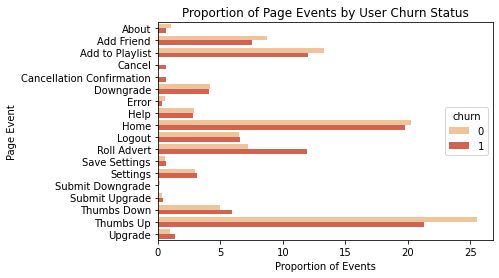

In [ ]:
# plot churn by page event
df_pages = df_churn.groupby(['page','churn']).count().toPandas()
df_pages = df_pages[df_pages['page'] != 'NextSong']
df_pages = ((df_pages.groupby(['page','churn']).sum() / df_pages.groupby(['churn']).sum()) *100).reset_index()
sns.barplot(y = 'page', x = 'count', palette='OrRd', data = df_pages, hue = 'churn')
plt.title("Proportion of Page Events by User Churn Status")
plt.ylabel('Page Event')
plt.xlabel('Proportion of Events')

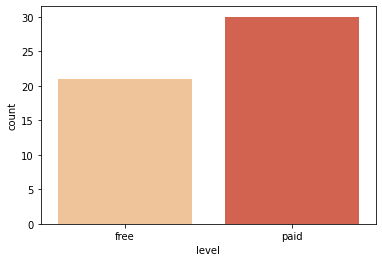

In [ ]:
# plot churn by account level
df_level = df_churn.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(x = 'level', y = 'count', palette='OrRd', data = df_level)



In [ ]:
df_churn_sql = df_churn.createOrReplaceTempView("user_table")

In [ ]:
# sql script to create feature list
df_training = spark.sql(
    '''
          SELECT DISTINCT
          userId,
          (CASE WHEN gender = 'M' THEN 0 ELSE 1 END) AS gender,
          (CASE WHEN level = 'free' THEN 0 ELSE 1 END) AS level,
          SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END) AS sum_add_playlist,
          SUM(CASE WHEN page = 'Downgrade' THEN 1 ELSE 0 END) AS downgrade_count,
          SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS error_count,
          SUM(CASE WHEN page = 'Help' THEN 1 ELSE 0 END) AS help_count,
          SUM(CASE WHEN page = 'Roll Advert' THEN 1 ELSE 0 END) AS roll_advert_count,
          SUM(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END) AS submit_downgrade_count,
          SUM(CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END) AS submit_upgrade_count,
          SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) AS thumbs_down_count,
          SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) AS thumbs_up_count,
          SUM(CASE WHEN page = 'Upgrade' THEN 1 ELSE 0 END) AS upgrade_count,
          COUNT(DISTINCT song) AS total_songs,
          COUNT(DISTINCT sessionId) AS total_sessions,
          MAX(ts - registration) AS account_lifetime,
          churn
          FROM user_table
          GROUP BY userId,churn,gender,level
    ''')

df_final = df_training.toPandas()

In [ ]:
print(df_final.shape)

(358, 17)


In [ ]:
assembler = VectorAssembler(inputCols=df_training.columns[1:-1], outputCol="FeatureVector")
features_vectored = assembler.transform(df_training)
scaler = StandardScaler(inputCol="FeatureVector", outputCol="features")
scaled = scaler.fit(features_vectored)
scaled = scaled.transform(features_vectored)

In [ ]:
scaled.head()

Row(userId='37', gender=0, level=0, sum_add_playlist=2, downgrade_count=0, error_count=0, help_count=3, roll_advert_count=3, submit_downgrade_count=0, submit_upgrade_count=1, thumbs_down_count=0, thumbs_up_count=2, upgrade_count=1, total_songs=43, total_sessions=4, account_lifetime=4409211000, churn=0, FeatureVector=DenseVector([0.0, 0.0, 2.0, 0.0, 0.0, 3.0, 3.0, 0.0, 1.0, 0.0, 2.0, 1.0, 43.0, 4.0, 4409211000.0]), features=DenseVector([0.0, 0.0, 0.0791, 0.0, 0.0, 0.563, 0.1656, 0.0, 1.4838, 0.0, 0.0408, 0.4361, 0.0605, 0.4082, 1.3164]))

In [ ]:
# rename columns for cross validation
df_final = scaled.select(['features', scaled['churn'].alias('label')])

In [ ]:
df_final.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0,0.079078...|    0|
|[2.00170789540886...|    0|
|[2.00170789540886...|    1|
|[0.0,2.0042543386...|    0|
|[2.00170789540886...|    0|
|[2.00170789540886...|    0|
|(15,[1,2,3,9,10,1...|    1|
|[0.0,2.0042543386...|    1|
|[0.0,2.0042543386...|    0|
|[2.00170789540886...|    0|
|[0.0,0.0,0.316313...|    0|
|[0.0,0.0,0.514009...|    1|
|[0.0,2.0042543386...|    0|
|[2.00170789540886...|    0|
|[2.00170789540886...|    0|
|[2.00170789540886...|    0|
|[0.0,0.0,0.434930...|    0|
|(15,[0,2,5,6,10,1...|    0|
|[0.0,0.0,0.197695...|    0|
|[0.0,2.0042543386...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
train, validation = df_final.randomSplit([0.9, 0.1], seed=42)

In [ ]:
validation.count()

29

In [ ]:
train.count()

329

In [ ]:
# initialize the classificaton models
lr = LogisticRegression(featuresCol ='features', labelCol = 'label')
rf = RandomForestClassifier(featuresCol ='features', labelCol = 'label')
gbt = GBTClassifier(featuresCol ='features', labelCol = 'label')
svm = LinearSVC(featuresCol ='features', labelCol = 'label')

In [ ]:
def train_models(model, train, validation):
    '''
    This function trains a model and predicts the target column. It also prints the f1 score.

    :param model: classification model to use.
    :param train: training data.
    :param validation: test data.
    '''
    clf = model.fit(train)
    pred = clf.transform(validation)
    evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
    f1score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    print('F1 Score:{}'.format(f1score))

    precision = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    print('Precision:', precision)

    recall = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    print('Recall:', recall)



In [ ]:
print('Linear Regression: ')
train_models(lr,train,validation)
print('Random Forest: ')
train_models(rf,train,validation)
print('Gradient Boosted Trees: ')
train_models(gbt,train,validation)
print('SVM: ')
train_models(svm,train,validation)

Linear Regression: 
F1 Score:0.46415396952686444
Precision: 0.4761273209549071
Recall: 0.5517241379310345
Random Forest: 
F1 Score:0.5065723548482168
Precision: 0.7697044334975369
Recall: 0.6206896551724137
Gradient Boosted Trees: 
F1 Score:0.6800692317933696
Precision: 0.6862068965517241
Recall: 0.6896551724137931
SVM: 
F1 Score:0.4332833583208396
Precision: 0.3436385255648038
Recall: 0.5862068965517241


THE BEST SCORE IS 0.6800692317933696


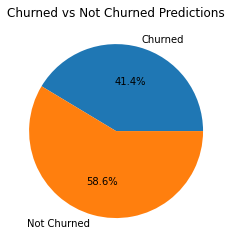

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
pipeline_lr = Pipeline(stages=[lr])

from pyspark.ml.classification import RandomForestClassifier,LinearSVC

rf = RandomForestClassifier()
pipeline_rf = Pipeline(stages=[rf])

svm = LinearSVC()
pipeline_svm = Pipeline(stages=[svm])

# Create a pipeline with the GBTClassifier
gbt = GBTClassifier()
pipeline = Pipeline(stages=[gbt])

#####
evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

# train and evaluate the models
models = {'Linear Regression': lr, 'Random Forest': rf, 'Gradient Boosted Trees': gbt, 'SVM': svm}
scores = {}
for name, model in models.items():
    clf = model.fit(train)
    pred = clf.transform(validation)
    f1score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    scores[name] = f1score

# find the best model
best_model_name = None
best_score = 0
for name, score in scores.items():
    if score > best_score:
        best_score = score
        best_model_name = name
best_model = models[best_model_name]
#####
print("THE BEST SCORE IS",best_score)
# Fit the pipeline to the training data
best_model = pipeline.fit(train)


# Make predictions on the validation dataset using the best model
predictions = best_model.transform(validation)

# Create a new column 'churn' that indicates whether a customer churned or not
predictions = predictions.withColumn("churn", when(predictions.label == 1, 'Churned').otherwise('Not Churned'))

# Count the number of true positives and false positives
churned = predictions.filter("churn = 'Churned'").count()
not_churned = predictions.filter("churn = 'Not Churned'").count()

# Create a list of the counts
counts = [churned, not_churned]

# Create a list of the labels for the pie chart
labels = ['Churned', 'Not Churned']

# Plot the pie chart
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Churned vs Not Churned Predictions')
plt.show()